Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [119]:
from random import random, seed
from itertools import product
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, set `REPRODUCIBILIY` to `True`

In [120]:
# Instance 1
# UNIVERSE_SIZE = 100
# NUM_SETS = 10
# DENSITY = 0.2

# Instance 2
# UNIVERSE_SIZE = 1_000
# NUM_SETS = 100
# DENSITY = 0.2

#Instance 3
UNIVERSE_SIZE = 10_000
NUM_SETS = 1000
DENSITY = 0.2

#Instance 4
# UNIVERSE_SIZE = 100_000
# NUM_SETS = 10_000
# DENSITY = 0.1

#Instance 5
# UNIVERSE_SIZE = 100_000
# NUM_SETS = 10_000
# DENSITY = 0.2

# Instance 6
# UNIVERSE_SIZE = 100_000
# NUM_SETS = 10_000
# DENSITY = 0.3

N_STEPS = 10_000

#Settings
REPRODUCIBILIY = False
PLOT_ACCEPTED_SOL_GRAPH = True


rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))
if REPRODUCIBILIY:
    random_gen = rng
else:
    random_gen = np.random



In [121]:
# DON'T EDIT THESE LINES!
SETS = random_gen.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        if REPRODUCIBILIY:
            SETS[random_gen.integers(NUM_SETS), s] = True
        else:
            SETS[random_gen.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [122]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(SETS[solution])
    return np.all(phenotype)


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Solution

In [123]:
def tweak(solution:np.ndarray)->np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(0,NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol

In [124]:
def fitness(solution:np.ndarray):
    return (valid(solution),-cost(solution))

In [125]:
used_simulated_annealing=0
accepted_invalid=0
def simulated_annealing(f_cur_sol: np.ndarray, f_tweaked_sol: np.ndarray, temperature: np.float64) -> np.float64:
    worse_p = np.exp((f_tweaked_sol - f_cur_sol) / temperature)
    global used_simulated_annealing

    is_accept = random_gen.random() <= worse_p
    if is_accept:
        used_simulated_annealing+=1
        # ic(temperature, worse_p)
    return is_accept

def accept_non_covering():
     is_accept = random_gen.random() <= 0.05
     return is_accept


## Hill Climbing with simulated annealing/accept non-covering
Gives priority to improving the current solution, accepts worse solutions (simulated annealing) as temperature increases. With some probability accepts (intermediate) non-covering solutions.\
Since the last test instances (with 10000 steps) keep improving the current solution, the probability of using simulated annealing and/or accepting non-covering solutions is low.

100%|██████████| 10000/10000 [00:01<00:00, 9649.88it/s]
ic| history.index(best_solution): 7221
    best_solution: (np.True_, np.float64(-132983.432347928))


Accepted worse solution (simulated annealing): 51 times
Accepted (intermediate) non-covering solutions: 14 times


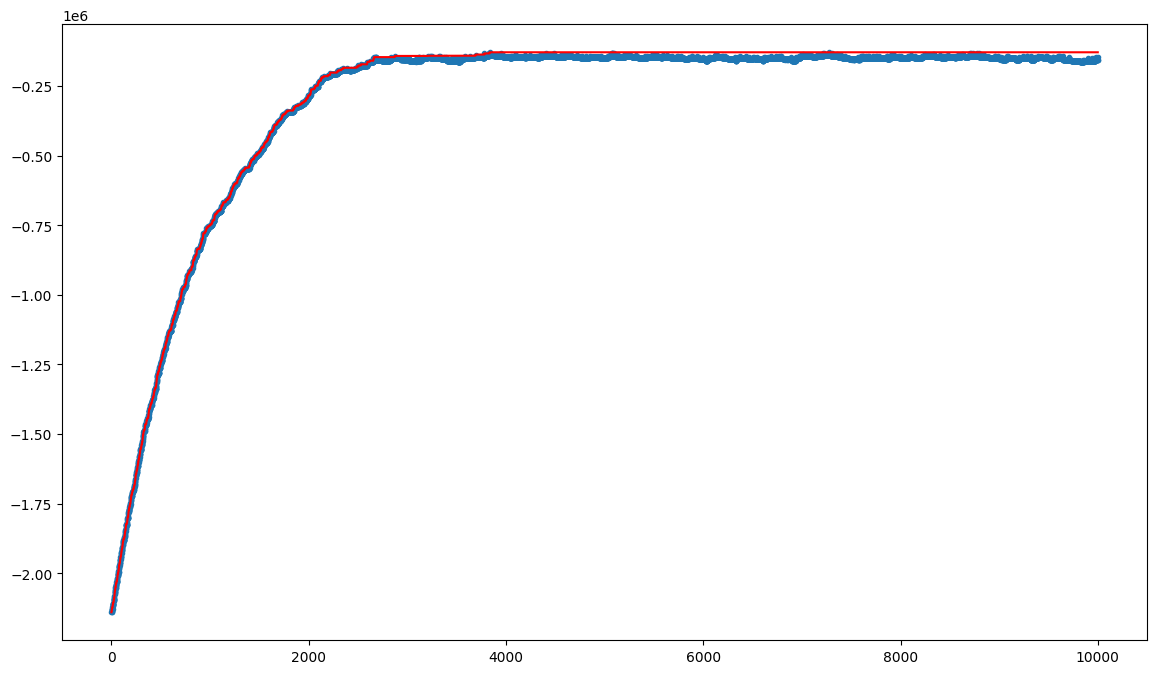

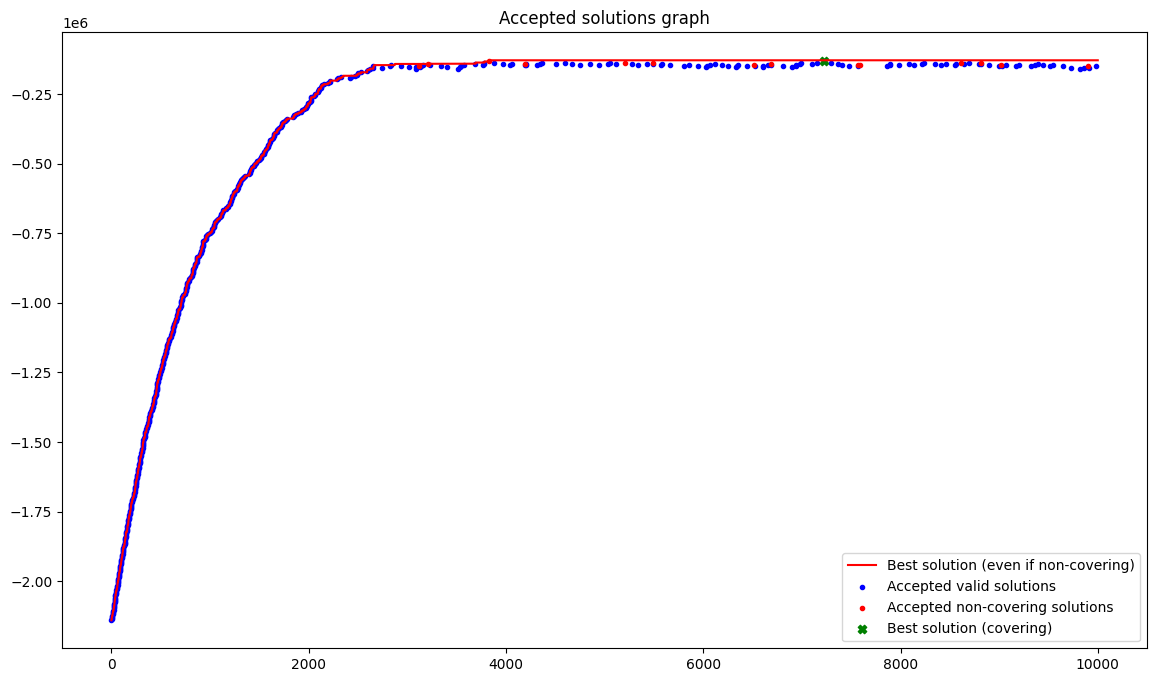

In [126]:
used_simulated_annealing=0
accepted_invalid=0
solution = rng.random(NUM_SETS) < 0.5
solution_fitness = fitness(solution)
history=[solution_fitness] if solution_fitness[0] else [] #if the initial solution is not valid, we don't want to store it in the history. NOTE: the history is a list of tuples (validity, cost) so that we can plot the accepted solutions graph if needed
best_solution = solution_fitness
STARTING_VALUE_TEMP = 1 
temperature = STARTING_VALUE_TEMP
accepted_sol_index= [0] if solution_fitness[0] else []

INC_VALUE = 15

ic.disable()
for steps in tqdm(range(N_STEPS)):
    new_solution = tweak(solution)
    f_newsol = fitness(new_solution)
    history.append(f_newsol)
    if  (best_solution[0]==False) or( #This line is for the edge cases where the starting solution is not valid, so we need to accept the first valid solution we find ignoring the cost (exit basin of attraction)
         (f_newsol[0] and f_newsol>solution_fitness ) # or if the new solution is valid and better than the current one (validity check cause after accepting an invalid solution the next one could be invalid too)
         or ( 
         #Next lines implement the simulated annealing and the acceptance of non-covering solutions
         (f_newsol[0] and simulated_annealing(solution_fitness[1],f_newsol[1],temperature)) # with a probability accept a worse solution
         or ( solution_fitness[0] and not f_newsol[0] and accept_non_covering()))) : # or with a probability accept an invalid solution (not allowed 2 invalid solutions in a row)
        ic("accepted",f_newsol)
        if f_newsol>best_solution and f_newsol[0]:
            best_solution=f_newsol
        if not f_newsol[0]: #will enter here if the best solution is invalid (so we accept any solution) or if with a probability we accepted an invalid solution
            accepted_invalid+=1
        accepted_sol_index.append(len(history)-1)
        solution=new_solution
        solution_fitness =  fitness(solution)
        temperature = STARTING_VALUE_TEMP #exploit the new solution first, then start again increasing the temperature
    else:
            temperature+= INC_VALUE #increase the temperature to explore the solution space

ic.enable()
print("Accepted worse solution (simulated annealing):",used_simulated_annealing, "times")
print("Accepted (intermediate) non-covering solutions:",accepted_invalid, "times")
ic(history.index(best_solution),best_solution)
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history),),
    [max(history[: i + 1], key= lambda x: x[1])[1] for i in range(len(history))],
    color="red",
)
plt.scatter(range(len(history)), [value for _, value in history], marker=".")
plt.show()

if(PLOT_ACCEPTED_SOL_GRAPH):
# Plotting the accepted solutions graph
    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history),),
        [max(history[: i + 1], key= lambda x: x[1])[1] for i in range(len(history))],
        color="red",
    )
    plt.scatter(
        [i for i, (flag, _) in enumerate(history) if flag and i in accepted_sol_index],
        [value for i, (flag, value) in enumerate(history) if flag and i in accepted_sol_index],
        color="blue",
        marker=".",
    )
    plt.scatter(
        [i for i, (flag, _) in enumerate(history) if not flag and i in accepted_sol_index],
        [value for i, (flag, value) in enumerate(history) if (flag==False) and i in accepted_sol_index],
        color="red",
        marker=".",
    )
    plt.scatter(
        history.index(best_solution),
        best_solution[1],
        color="green",
        marker="X",
    )
    plt.title("Accepted solutions graph")
    plt.legend(["Best solution (even if non-covering)", "Accepted valid solutions", "Accepted non-covering solutions", "Best solution (covering)"])
    plt.show()

